In [7]:
import os
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2
import supervision as sv

#!pip install -q "git+https://github.com/facebookresearch/segment-anything.git"
#!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

Нужно создать папку weights и положить туда файлик по с весами по ссылке

In [8]:
#!mkdir -p weights
#!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P weights

CHECKPOINT_PATH = os.path.join("weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

weights\sam_vit_h_4b8939.pth ; exist: True


In [9]:
IMAGE_PATH = "picture.jpg"
CHECKPOINT_PATH = os.path.join("weights", "sam_vit_h_4b8939.pth")

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [10]:
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

In [12]:
class Segmentator:
    def __init__(self, path, device):
        self.path = path
        self.model_type = "vit_h"
        self.device = device
        self.model = sam_model_registry[self.model_type](checkpoint=self.path).to(device=self.device)
        self.mask_generator = SamAutomaticMaskGenerator(self.model)
        self.mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

    def predict(self, image):
        result = [el for el in self.mask_generator.generate(image)
                      if el["stability_score"] > 0.975]
        return result

    def annotate(self, image, result):
        detections = sv.Detections.from_sam(sam_result=result)
        annotated_image = self.mask_annotator.annotate(scene=image.copy(),
                                                       detections=detections)
        return annotated_image

In [13]:
model = Segmentator(CHECKPOINT_PATH, DEVICE)

In [15]:
# Выходы модели
result = model.predict(image_rgb)

In [17]:
# Размеченная картинка (предикты наложены на изображение)
annotation = model.annotate(image_rgb, result)

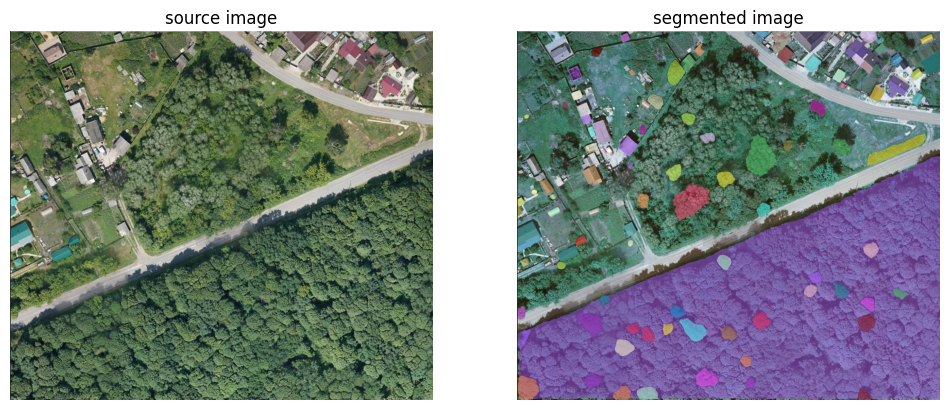

In [19]:
# Красиво выводим
sv.plot_images_grid(
    images=[image_bgr, annotation],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)